In [1]:
import numpy as np
import pandas as pd
import pyro.distributions as dist
import torch
import scipy.stats as stats
import subprocess as sb

from itertools import combinations

import matplotlib.pyplot as plt
import sys
import os
from natsort import natsorted
import re

parent_dir = "../../"
sys.path.insert(0, parent_dir)
from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

/Users/elenarivaroli/miniconda3/envs/mobster/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Synthetic samples

In [2]:
def euclidean_distance(a, b):
    return torch.dist(a, b)

# Define the Pareto-Binomial function
def pareto_binomial(N, alpha, L, H, depth):
    p = BoundedPareto(scale=L, alpha=alpha, upper_limit=H).sample((N,))
    bin = dist.Binomial(total_count=depth, probs=p).sample()
    min_bin = torch.ceil(L * depth)
    max_bin = torch.ceil(H * depth)
    # bin = torch.max(bin, min_bin)
    while torch.any(bin > max_bin):
        mask = bin > max_bin
        bin[mask] = dist.Binomial(total_count=depth[mask], probs=p[mask]).sample()
    while torch.any(bin < min_bin):
        mask = bin < min_bin
        bin[mask] = dist.Binomial(total_count=depth[mask], probs=p[mask]).sample()
        
    return bin


# Define the Beta-Binomial function
def beta_binomial(N, phi, kappa, depth, L):
    a = phi * kappa
    b = (1 - phi) * kappa
    p = dist.Beta(a, b).sample((N,))
    bin = dist.Binomial(total_count=depth, probs=p).sample()
    min_bin = torch.ceil(L * depth)
    while torch.any(bin < min_bin):
        mask = bin < min_bin
        bin[mask] = dist.Binomial(total_count=depth[mask], probs=p[mask]).sample()
    return bin

def sample_mixing_prop(K, min_value=0.05):
    while True: # loop until valid sample
        sample = dist.Dirichlet(torch.ones(K)).sample()
        if (sample > min_value).all():
            return sample


In [39]:
def generate_data_new_model(N, K, pi, D, purity, coverage):
    NV = torch.zeros((N, D))
    threshold=0.15
    cluster_labels = torch.zeros(N)  # one-dimensional labels, one per data
    type_labels_data = torch.zeros((N, D))  # D-dimensional labels, one per data
    type_labels_cluster = torch.zeros((K, D))  # D-dimensional label, one per cluster
    phi_param_data = torch.zeros((N, D))
    kappa_param_data = torch.zeros((N, D))
    alpha_param_data = torch.zeros((N, D))
    phi_param_cluster = torch.zeros((K, D))
    kappa_param_cluster = torch.zeros((K, D))
    alpha_param_cluster = torch.zeros((K, D))
    max_vaf = purity/2
    min_phi = 0.12
    probs_pareto = 0.08
    pareto_L = torch.tensor(0.03)  # Scale Pareto
    pareto_H = torch.tensor(max_vaf)  # Upper bound Pareto
    # variance_negbin = 1000
    # mean_negbin = coverage
    # probs_negbin = mean_negbin/variance_negbin
    # n_negbin = mean_negbin**2/(variance_negbin-mean_negbin)
    # neg_bin = stats.nbinom.rvs(n_negbin, probs_negbin, size=N*D)
    # depth = torch.tensor(neg_bin).reshape([N,D])
    depth = dist.Poisson(coverage).sample([N,D])

    sampled_phi_list = []

    # Always have a Beta-Binomial component with phi=max_vaf in all dimensions
    k = 0
    for d in range(D):
        p = max_vaf
        kappa = dist.Uniform(90, 350).sample()
        NV[:pi[k], d] = beta_binomial(pi[k], p, kappa, depth[:pi[k],d], pareto_L)
        type_labels_data[:pi[k], d] = torch.tensor(1)  # beta
        type_labels_cluster[k, d] = torch.tensor(1)  # beta
        phi_param_data[:pi[k], d] = p
        kappa_param_data[:pi[k], d] = round(kappa.item(), 3)
        alpha_param_data[:pi[k], d] = -1
        phi_param_cluster[k, d] = p
        kappa_param_cluster[k, d] = round(kappa.item(), 3)
        alpha_param_cluster[k, d] = -1
    cluster_labels[:pi[k]] = k  # cluster k
    sampled_phi_list.append(torch.tensor([p] * D))

    # Always have a Pareto-Binomial component in all dimensions
    k = 1

    init_idx = np.sum(pi[:k])
    end_idx = init_idx + pi[k]
    for d in range(D):
        alpha = dist.Uniform(0.8, 1.5).sample()  # Pareto shape parameter
        NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
        type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
        type_labels_cluster[k, d] = torch.tensor(0)  # pareto
        phi_param_data[init_idx:end_idx, d] = -1
        kappa_param_data[init_idx:end_idx, d] = -1
        alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
        phi_param_cluster[k, d] = -1
        kappa_param_cluster[k, d] = -1
        alpha_param_cluster[k, d] = round(alpha.item(), 3)
    cluster_labels[init_idx:end_idx] = k  # cluster k
    sampled_phi_list.append(torch.tensor([probs_pareto] * D))

    # Randomly sample from Beta-Binomial, Pareto-Binomial or Zeros for additional components
    for k in range(2, K):
        init_idx = np.sum(pi[:k])
        end_idx = init_idx + pi[k]
        pareto_count = 0
        zeros_count = 0
        cluster_labels[init_idx:end_idx] = k  # cluster k
        while True:
            curr_sampled_phi = []
            for d in range(D):
                choose_dist = torch.randint(1, 4, (1,)).item() # randomly sample a value between 1, 2 or 3
                if choose_dist == 1:
                    phi, kappa = dist.Uniform(min_phi, max_vaf).sample(), dist.Uniform(150, 350).sample()
                    NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d],pareto_L)
                    type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                    type_labels_cluster[k, d] = torch.tensor(1)  # beta
                    phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                    kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                    alpha_param_data[init_idx:end_idx, d] = -1
                    phi_param_cluster[k, d] = round(phi.item(), 3)
                    kappa_param_cluster[k, d] = round(kappa.item(), 3)
                    alpha_param_cluster[k, d] = -1
                    curr_sampled_phi.append(phi)
                elif choose_dist == 2: # Pareto-Binomial for this dimension
                    if pareto_count >= (D-1): 
                        # if the number of pareto dimensions are already D-1 (all but 1), then sample either a beta or zeros
                        if torch.rand(1).item() < 0.5 and zeros_count < (D-1): # zeros
                            phi = 0
                            type_labels_cluster[k, d] = torch.tensor(2)  # zeros
                            NV[init_idx:end_idx, d] = phi
                            phi_param_data[init_idx:end_idx, d] = -1
                            kappa_param_data[init_idx:end_idx, d] = -1
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = -1
                            kappa_param_cluster[k, d] = -1
                            alpha_param_cluster[k, d] = -1
                            zeros_count += 1
                            curr_sampled_phi.append(phi)                            
                        else: # beta
                            phi, kappa = dist.Uniform(min_phi, max_vaf).sample(), dist.Uniform(150, 350).sample()
                            NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d],pareto_L)
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                            type_labels_cluster[k, d] = torch.tensor(1)  # beta
                            phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                            kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = round(phi.item(), 3)
                            kappa_param_cluster[k, d] = round(kappa.item(), 3)
                            alpha_param_cluster[k, d] = -1                            
                            curr_sampled_phi.append(phi)
                            
                    else: # pareto
                        alpha = dist.Uniform(0.8, 1.5).sample()
                        NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
                        type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
                        type_labels_cluster[k, d] = torch.tensor(0)  # pareto
                        phi_param_data[init_idx:end_idx, d] = -1
                        kappa_param_data[init_idx:end_idx, d] = -1
                        alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
                        phi_param_cluster[k, d] = -1
                        kappa_param_cluster[k, d] = -1
                        alpha_param_cluster[k, d] = round(alpha.item(), 3)
                        pareto_count += 1
                        curr_sampled_phi.append(probs_pareto)
                elif choose_dist == 3: # Zeros for this dimension
                    if zeros_count >= (D-1): 
                        # if the number of zeros dimensions are already D-1 (all but 1), then sample either a beta or a pareto
                        # if torch.rand(1).item() < 0.5 and pareto_count < (D-1):  # zeros
                        if torch.rand(1).item() < 0.5:  # zeros
                            alpha = dist.Uniform(0.8, 1.5).sample()
                            NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
                            type_labels_cluster[k, d] = torch.tensor(0)  # pareto
                            phi_param_data[init_idx:end_idx, d] = -1
                            kappa_param_data[init_idx:end_idx, d] = -1
                            alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
                            phi_param_cluster[k, d] = -1
                            kappa_param_cluster[k, d] = -1
                            alpha_param_cluster[k, d] = round(alpha.item(), 3)
                            pareto_count += 1
                            curr_sampled_phi.append(probs_pareto)
                        else: # beta
                            phi, kappa = dist.Uniform(min_phi, max_vaf).sample(), dist.Uniform(150, 350).sample()
                            NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d],pareto_L)
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                            type_labels_cluster[k, d] = torch.tensor(1)  # beta
                            phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                            kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = round(phi.item(), 3)
                            kappa_param_cluster[k, d] = round(kappa.item(), 3)
                            alpha_param_cluster[k, d] = -1
                            curr_sampled_phi.append(phi)
                    else:
                        phi = 0
                        type_labels_cluster[k, d] = torch.tensor(2)  # zeros
                        NV[init_idx:end_idx, d] = phi
                        phi_param_data[init_idx:end_idx, d] = -1
                        kappa_param_data[init_idx:end_idx, d] = -1
                        alpha_param_data[init_idx:end_idx, d] = -1
                        phi_param_cluster[k, d] = -1
                        kappa_param_cluster[k, d] = -1
                        alpha_param_cluster[k, d] = -1
                        zeros_count += 1
                        curr_sampled_phi.append(pareto_L - threshold)

            
            # Convert curr_sampled_phi to a tensor
            curr_sampled_phi_tensor = torch.tensor(curr_sampled_phi)
            
            # Check if curr_sampled_phi list has a euclidean distance < threshold from all the already present element in sampled_phi_list:
            # if yes, add it to sampled_phi_list and go to the next iteration of k, otherwise repeat this loop over d
            
            # Check if the Euclidean distance is below the threshold for any sampled_phi in sampled_phi_list
            if all(euclidean_distance(curr_sampled_phi_tensor, phi) >= threshold for phi in sampled_phi_list):
                # If no element in sampled_phi_list is too close, add to sampled_phi_list and break the loop
                sampled_phi_list.append(curr_sampled_phi_tensor)
                break  # Move to the next cluster
    return NV, depth, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster

In [40]:
def plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_beta, kappa_beta, alpha, idx):
    vaf = NV/DP
    copy_vaf = torch.clone(vaf)
    # Replace zeros with a large value that will not be considered as minimum (i.e. 1)
    masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

    # Find the minimum value for each column excluding zeros
    min_values, _ = torch.min(masked_tensor, dim=0)
    min_values = min_values.repeat(K, 1)
    pareto_L = torch.min(min_values)
    print(min_values, pareto_L)
    if K == 1:
        fig, axes = plt.subplots(K, NV.shape[1], figsize=(16, 4))
    else:
        fig, axes = plt.subplots(K, NV.shape[1], figsize=(16, K*3))
    if K == 1:
        axes = ax = np.array([axes])  # add an extra dimension to make it 2D
    plt.suptitle(f"Marginals with N = {N} and {K} clusters (i = {idx}) \n ")
    x = np.linspace(0.001, 1, 1000)
    for k in range(K):
        for d in range(D):
            maxx = type_labels_cluster[k, d]
            if maxx == 1:
                # plot beta
                a = phi_beta[k,d] * kappa_beta[k,d]
                b = (1-phi_beta[k,d]) * kappa_beta[k,d]
                pdf = beta.pdf(x, a, b)
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Beta', color='r')
                axes[k,d].legend()
            elif maxx == 0:
                #plot pareto
                # print(alpha[k,d])
                pdf = pareto.pdf(x, alpha[k,d], scale=pareto_L)
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Pareto', color='g')
                axes[k,d].legend()
            elif maxx == 2:
                # private
                a_beta_zeros = torch.tensor(1e-3)
                b_beta_zeros = torch.tensor(1e3)
                pdf = beta.pdf(x, a_beta_zeros, b_beta_zeros) # delta_approx
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Zeros', color='b')
                axes[k,d].legend()
            
            if torch.is_tensor(NV):
                data = NV[:,d].numpy()/DP[:,d].numpy()
            else:
                data = np.array(NV[:,d])/np.array(DP[:,d])
            # data = mb.NV[:,d].numpy()/mb.DP[:,d].numpy()
            # for i in np.unique(labels):
            axes[k,d].hist(data[cluster_labels == k], density=True, bins=30, alpha=0.5)#, color=cmap(i))
            axes[k,d].set_title(f"Sample {d+1} - Cluster {k}")
            axes[k,d].set_xlim([-0.01,1])
            plt.tight_layout()
    # plt.savefig(f"plots/real_marginals/N_{N}_K_{K}_D_{D}_real_{idx}.png")
    plt.show()
    plt.close()


tensor([0.4820, 0.3206, 0.1215, 0.0758])
tensor([4819.7012, 3206.4885, 1215.3940,  758.4163])
np.sum(pi) 9999
tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.4240,  0.9510,  1.1450],
        [ 0.9080, -1.0000, -1.0000],
        [-1.0000,  1.0540,  0.8580]])


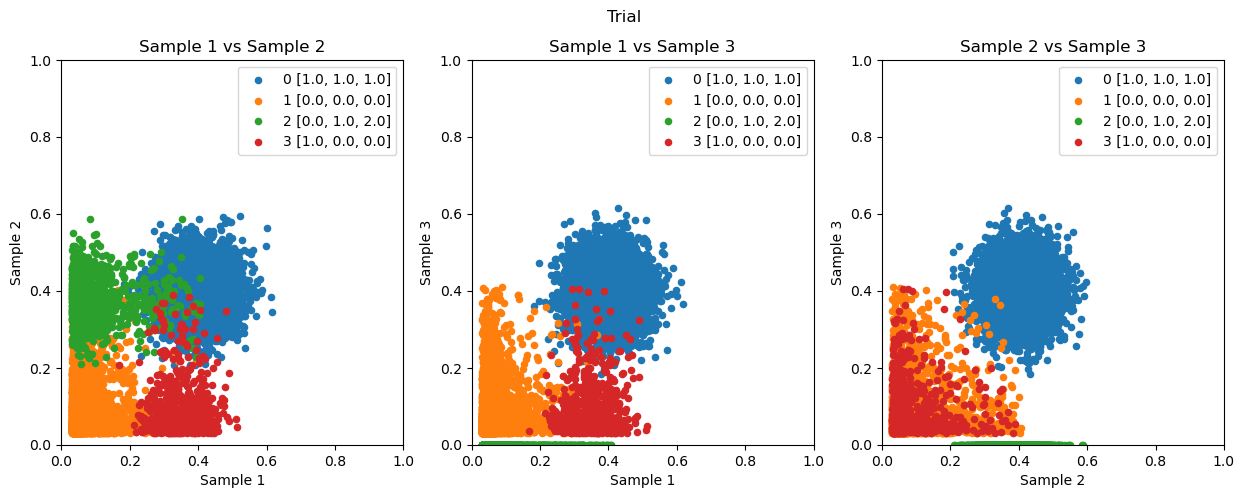

tensor([[0.0300, 0.0300, 0.0300],
        [0.0300, 0.0300, 0.0300],
        [0.0300, 0.0300, 0.0300],
        [0.0300, 0.0300, 0.0300]]) tensor(0.0300)


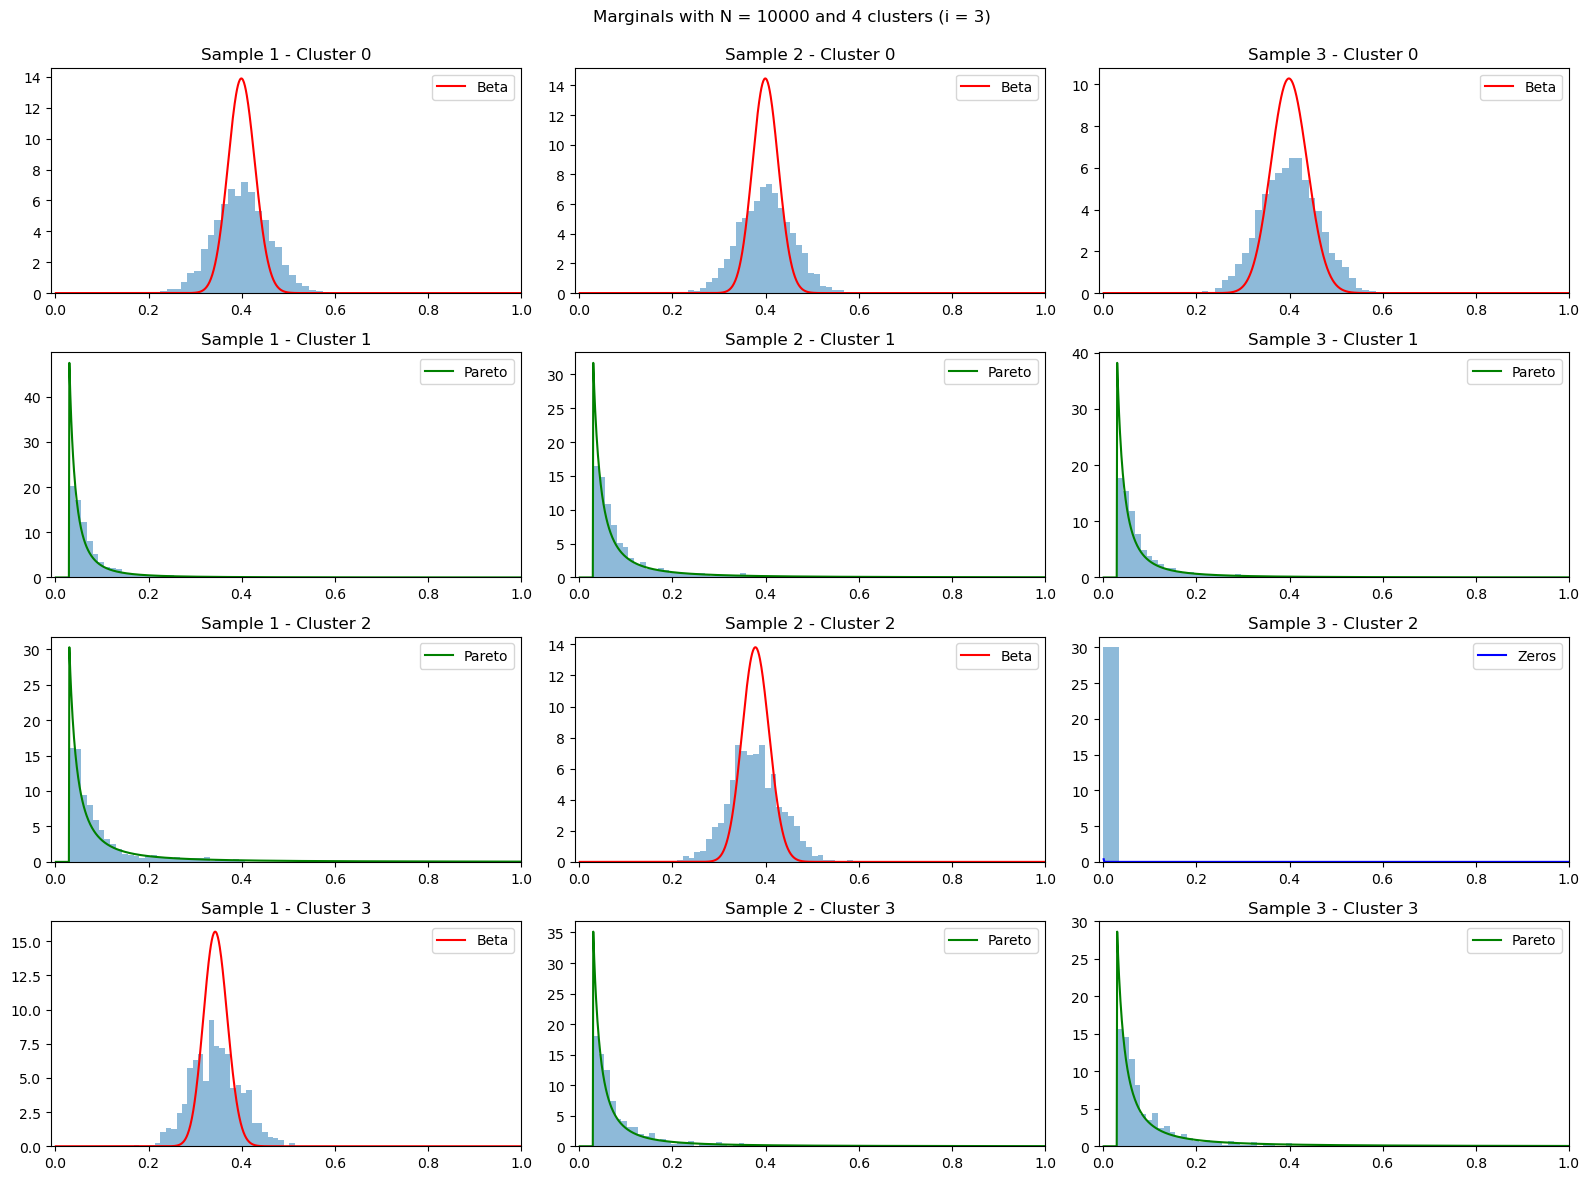

In [75]:
purity = 0.8
coverage = 100
N = 10000
K = 4
D = 3

seed1 = 40
# pyro.set_rng_seed(seed1)
# torch.manual_seed(seed1)
# np.random.seed(seed1)

# Sample mixing proportions for clusters and multiply by N to obtain the number of data in each cluster
pi = sample_mixing_prop(K) * N
print(pi/N)
print(pi)
# pi = dist.Dirichlet(torch.ones(K)).sample() * N  # Number of data in each cluster
pi = np.round(pi.numpy()).astype('int')

# Adjust proportions to ensure they sum to N
print("np.sum(pi)", np.sum(pi))
if np.sum(pi) < N:
    diff = N - np.sum(pi)
    pi[-1] += diff
elif np.sum(pi) > N:
    diff = np.sum(pi) - N
    pi[-1] -= diff
NV, DP, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster  = generate_data_new_model(N, K, pi, D, purity, coverage)
print(alpha_param_cluster)
pairs = np.triu_indices(D, k=1)  # Generate all unique pairs of samples (i, j)
vaf = NV/DP    
num_pairs = len(pairs[0])  # Number of unique pairs
ncols = min(3, num_pairs)
nrows = (num_pairs + ncols - 1) // ncols  # Calculate the number of rows

fig_width_per_plot = 5
fig_width = ncols * fig_width_per_plot
fig_height = 5 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
plt.suptitle('Trial')
if num_pairs == 1:
    axes = [axes]
else:
    axes = axes.flatten()

idx = 0
for i, j in zip(*pairs):
    ax = axes[idx]  # Select the appropriate subplot
    x = vaf[:, i].numpy()
    y = vaf[:, j].numpy()

    # ax.scatter(x, y, alpha=0.7)

    for c, cluster in enumerate(np.unique(cluster_labels)):
        mask = (cluster_labels == cluster)  # Mask for current cluster
        ax.scatter(x[mask], 
                    y[mask],
                    label=f'{cluster.astype("int")} {type_labels_cluster[c].tolist()}', s = 20)
    ax.legend(loc='best')
    ax.set_title(f"Sample {i+1} vs Sample {j+1}")
    ax.set_xlabel(f"Sample {i+1}")
    ax.set_ylabel(f"Sample {j+1}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    idx += 1

plt.show()
plt.close()

plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_param_cluster, kappa_param_cluster, alpha_param_cluster, idx)

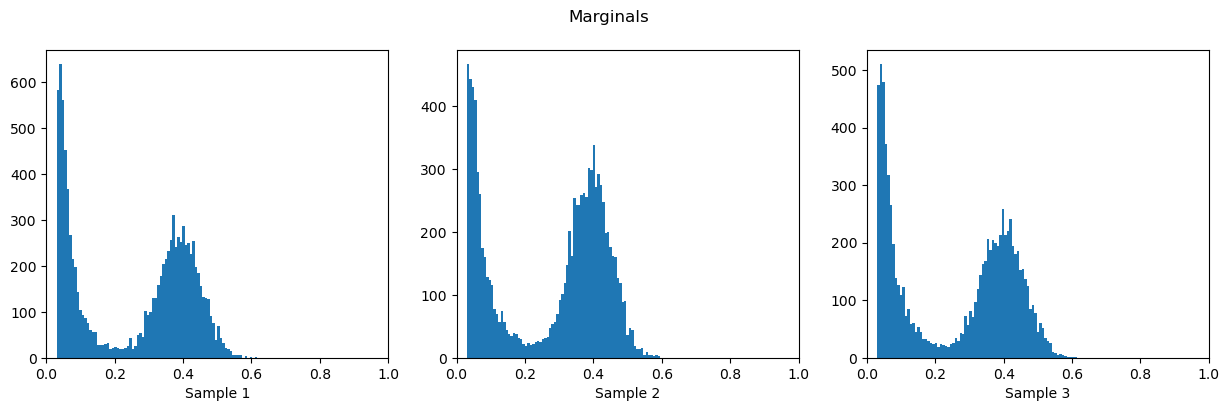

In [76]:
vaf = NV/DP
fig, axes = plt.subplots(1, D, figsize=(5*D, 4))
plt.suptitle("Marginals")

for i in range(D):
    x = vaf[:, i].numpy()
    x = x[x > 0]
    axes[i].hist(x, bins = 80)
    
    axes[i].set_xlabel(f"Sample {i+1}")
    axes[i].set_xlim([0,1])

plt.show()

In [77]:
# Generate mutation IDs
mutation_ids = [f"M{i}" for i in range(N)]
# mutation_ids

In [78]:
NV

tensor([[44., 42., 31.],
        [36., 39., 35.],
        [35., 41., 35.],
        ...,
        [39.,  8.,  7.],
        [36.,  8., 14.],
        [23., 11.,  5.]])

In [79]:
# Create D DataFrames
dataframes = []
for d in range(NV.shape[1]):
    df = pd.DataFrame({
        "alt_counts": NV[:, d].numpy().astype(int),
        "ref_counts": DP[:, d].numpy().astype(int),
        "mutation_id": mutation_ids,
        "sample_id": f"S_{d}",
        "major_cn": 1,
        "minor_cn": 1,
        "normal_cn": 1,
        "tumour_content": purity,
        "VAF": NV[:, d].numpy()/DP[:, d].numpy()
    })
    dataframes.append(df)

In [80]:
for d, df in enumerate(dataframes):
    print(f"DataFrame {d}:")
    print(df, "\n")

DataFrame 0:
      alt_counts  ref_counts mutation_id sample_id  major_cn  minor_cn  \
0             44          91          M0       S_0         1         1   
1             36          92          M1       S_0         1         1   
2             35          85          M2       S_0         1         1   
3             37         100          M3       S_0         1         1   
4             44         106          M4       S_0         1         1   
...          ...         ...         ...       ...       ...       ...   
9995          40          95       M9995       S_0         1         1   
9996          37         101       M9996       S_0         1         1   
9997          39         110       M9997       S_0         1         1   
9998          36         105       M9998       S_0         1         1   
9999          23         101       M9999       S_0         1         1   

      normal_cn  tumour_content       VAF  
0             1             0.8  0.483516  
1         

In [81]:
combined_df = pd.concat(dataframes, axis=0, ignore_index=True)
print(combined_df)

       alt_counts  ref_counts mutation_id sample_id  major_cn  minor_cn  \
0              44          91          M0       S_0         1         1   
1              36          92          M1       S_0         1         1   
2              35          85          M2       S_0         1         1   
3              37         100          M3       S_0         1         1   
4              44         106          M4       S_0         1         1   
...           ...         ...         ...       ...       ...       ...   
29995           5          89       M9995       S_2         1         1   
29996           7          66       M9996       S_2         1         1   
29997           7         117       M9997       S_2         1         1   
29998          14         104       M9998       S_2         1         1   
29999           5          79       M9999       S_2         1         1   

       normal_cn  tumour_content       VAF  
0              1             0.8  0.483516  
1        

In [82]:
folder_path = f'data/p_{str(purity).replace(".", "")}_cov_{coverage}/D_{D}'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [83]:
# 'data/p_{str(purity).replace(".", "")}_cov_{coverage}/D_{D}/N_{N}_K_{K}_D_{D}_real_{idx_real}.tsv'
idx_real = 0
data_path = f'data/p_{str(purity).replace(".", "")}_cov_{coverage}/D_{D}/N_{N}_K_{K}_D_{D}_real_{idx_real}.tsv'
combined_df.to_csv(data_path,  sep='\t', index=False)

In [84]:
fit_path = f'data/p_{str(purity).replace(".", "")}_cov_{coverage}/D_{D}/N_{N}_K_{K}_D_{D}_fit_{idx_real}.h5'
best_fit_path = f'data/p_{str(purity).replace(".", "")}_cov_{coverage}/D_{D}/N_{N}_K_{K}_D_{D}_best_fit_{idx_real}.h5'

In [85]:
max_K = K + 3
# max_K = 10
sb.call('pyclone-vi fit -i '+data_path+' -o '+fit_path+' -c '+ str(max_K) + ' -d beta-binomial -r 10', shell = True)


Num Samples: 3
Samples: S_0 S_1 S_2
Num mutations: 10000
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -490844.22340639203
Number of clusters used: 7

Fitting completed
ELBO: -113798.44751666072
Number of clusters used: 2

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -1167318.6033880622
Number of clusters used: 7

Fitting completed
ELBO: -103262.26611337592
Number of clusters used: 3

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -717519.3400092653
Number of clusters used: 7

Fitting completed
ELBO: -99596.7923665343
Number of clusters used: 4

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -598966.8517412642
Number of clusters used: 7

Fitting completed
ELBO: -103262.26611918793
Number of clusters used: 3

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -502339.99673250236
Number of clusters used: 7

Fitting completed
ELBO: -99604.6117160665
N

0

In [86]:
sb.call('pyclone-vi write-results-file -i '+fit_path+' -o '+best_fit_path, shell = True)

/Users/elenarivaroli/miniconda3/envs/mobster/lib/python3.11/site-packages/pyclone_vi/post_process.py:64: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


0

In [87]:
fit = pd.read_csv(best_fit_path, sep='\t')

In [88]:
fit['cluster_id'].unique()

array([0, 1, 2, 3])

In [89]:
# What is the prevalence of clusters across samples?
#table_cellular_prevalence = 
fit.groupby('cluster_id')['cellular_prevalence'].apply(lambda x: list(set(x))).reset_index()

,cluster_id,cellular_prevalence
0,0,"[0.101, 0.1313]"
1,1,"[0.4687, 0.1313, 0.1213]"
2,2,"[0.1414, 0.5534, 0.0]"
3,3,"[0.5845, 0.5855, 0.5764]"


In [90]:
#table_cellular_prevalence['cellular_prevalence']

In [91]:
data = combined_df

In [92]:
data

,alt_counts,ref_counts,mutation_id,sample_id,major_cn,minor_cn,normal_cn,tumour_content,VAF
0,44,91,M0,S_0,1,1,1,0.8,0.483516
1,36,92,M1,S_0,1,1,1,0.8,0.391304
2,35,85,M2,S_0,1,1,1,0.8,0.411765
3,37,100,M3,S_0,1,1,1,0.8,0.370000
4,44,106,M4,S_0,1,1,1,0.8,0.415094
...,...,...,...,...,...,...,...,...,...
29995,5,89,M9995,S_2,1,1,1,0.8,0.056180
29996,7,66,M9996,S_2,1,1,1,0.8,0.106061
29997,7,117,M9997,S_2,1,1,1,0.8,0.059829
29998,14,104,M9998,S_2,1,1,1,0.8,0.134615


In [93]:
data['sample_id'] = data['sample_id'].astype(str)
fit['sample_id'] = fit['sample_id'].astype(str)

In [94]:
final_df = data.merge(fit, on=['mutation_id', 'sample_id'], how='left')
final_df.columns

Index(['alt_counts', 'ref_counts', 'mutation_id', 'sample_id', 'major_cn',
       'minor_cn', 'normal_cn', 'tumour_content', 'VAF', 'cluster_id',
       'cellular_prevalence', 'cellular_prevalence_std',
       'cluster_assignment_prob'],
      dtype='object')

In [95]:
fitted_data = pd.merge(data, fit, how = 'outer', on=['mutation_id','sample_id'])
fitted_data

,alt_counts,ref_counts,mutation_id,sample_id,major_cn,minor_cn,normal_cn,tumour_content,VAF,cluster_id,cellular_prevalence,cellular_prevalence_std,cluster_assignment_prob
0,44,91,M0,S_0,1,1,1,0.8,0.483516,3,0.5845,0.0035,1.0000
1,42,98,M0,S_1,1,1,1,0.8,0.428571,3,0.5855,0.0019,1.0000
2,31,89,M0,S_2,1,1,1,0.8,0.348315,3,0.5764,0.0025,1.0000
3,36,92,M1,S_0,1,1,1,0.8,0.391304,3,0.5845,0.0035,1.0000
4,39,105,M1,S_1,1,1,1,0.8,0.371429,3,0.5855,0.0019,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,8,68,M9998,S_1,1,1,1,0.8,0.117647,1,0.1213,0.0009,0.9993
29996,14,104,M9998,S_2,1,1,1,0.8,0.134615,1,0.1313,0.0001,0.9993
29997,23,101,M9999,S_0,1,1,1,0.8,0.227723,1,0.4687,0.0051,0.9670
29998,11,107,M9999,S_1,1,1,1,0.8,0.102804,1,0.1213,0.0009,0.9670


In [96]:
table_to_print = fitted_data.pivot_table(index = ['mutation_id','cluster_id'], columns = 'sample_id', values = 'VAF', aggfunc = 'first').reset_index()
        

In [97]:
result = (
    fitted_data.pivot_table(
        index=['mutation_id', 'cluster_id'],  # Grouping columns
        columns='sample_id',  # Columns to pivot on
        values=['alt_counts', 'ref_counts', 'VAF', 'cellular_prevalence'],  # Values to pivot
        aggfunc='first'  # In case of duplicates
    )
    .reset_index()  # Reset index for a flat DataFrame
)

# Flatten the MultiIndex columns
result.columns = ['_'.join(filter(None, col)).strip('_') for col in result.columns]
# result.sort_values(by='mutation_id').reset_index(drop=True)
result_sorted = result.reindex(natsorted(result.index, key=lambda x: result.loc[x, 'mutation_id'])).reset_index(drop=True)

column_prefixes = ['alt_counts', 'ref_counts', 'cellular_prevalence', 'VAF']
columns_to_unify = {
    prefix: [col for col in result_sorted.columns if re.match(f"{prefix}_S_\\d+", col)]
    for prefix in column_prefixes
}

for new_col, cols in columns_to_unify.items():
    result_sorted[new_col] = result_sorted[cols].values.tolist()

result_sorted = result_sorted.drop(columns=[col for cols in columns_to_unify.values() for col in cols])
result_sorted = result_sorted.drop(columns=['VAF', 'mutation_id'])
result_sorted.rename(columns={"alt_counts": "NV", "ref_counts": "DP", "cluster_id": "Pred_cluster"}, inplace=True)
result_sorted      

,Pred_cluster,NV,DP,cellular_prevalence
0,3,"[44, 42, 31]","[91, 98, 89]","[0.5845, 0.5855, 0.5764]"
1,3,"[36, 39, 35]","[92, 105, 94]","[0.5845, 0.5855, 0.5764]"
2,3,"[35, 41, 35]","[85, 98, 94]","[0.5845, 0.5855, 0.5764]"
3,3,"[37, 40, 48]","[100, 109, 112]","[0.5845, 0.5855, 0.5764]"
4,3,"[44, 41, 29]","[106, 102, 112]","[0.5845, 0.5855, 0.5764]"
...,...,...,...,...
9995,1,"[40, 13, 5]","[95, 109, 89]","[0.4687, 0.1213, 0.1313]"
9996,3,"[37, 26, 7]","[101, 101, 66]","[0.5845, 0.5855, 0.5764]"
9997,1,"[39, 8, 7]","[110, 99, 117]","[0.4687, 0.1213, 0.1313]"
9998,1,"[36, 8, 14]","[105, 68, 104]","[0.4687, 0.1213, 0.1313]"


In [98]:
result = (
            fitted_data.pivot_table(
                index=['mutation_id', 'cluster_id'],  # Grouping columns
                columns='sample_id',  # Columns to pivot on
                values=['alt_counts', 'ref_counts', 'VAF', 'cellular_prevalence'],  # Values to pivot
                aggfunc='first'  # In case of duplicates
            )
            .reset_index()  # Reset index for a flat DataFrame
        )

# Flatten the MultiIndex columns
result.columns = ['_'.join(filter(None, col)).strip('_') for col in result.columns]
# result.sort_values(by='mutation_id').reset_index(drop=True)
result_sorted = result.reindex(natsorted(result.index, key=lambda x: result.loc[x, 'mutation_id'])).reset_index(drop=True)
result_sorted

,mutation_id,cluster_id,VAF_S_0,VAF_S_1,VAF_S_2,alt_counts_S_0,alt_counts_S_1,alt_counts_S_2,cellular_prevalence_S_0,cellular_prevalence_S_1,cellular_prevalence_S_2,ref_counts_S_0,ref_counts_S_1,ref_counts_S_2
0,M0,3,0.483516,0.428571,0.348315,44,42,31,0.5845,0.5855,0.5764,91,98,89
1,M1,3,0.391304,0.371429,0.372340,36,39,35,0.5845,0.5855,0.5764,92,105,94
2,M2,3,0.411765,0.418367,0.372340,35,41,35,0.5845,0.5855,0.5764,85,98,94
3,M3,3,0.370000,0.366972,0.428571,37,40,48,0.5845,0.5855,0.5764,100,109,112
4,M4,3,0.415094,0.401961,0.258929,44,41,29,0.5845,0.5855,0.5764,106,102,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M9995,1,0.421053,0.119266,0.056180,40,13,5,0.4687,0.1213,0.1313,95,109,89
9996,M9996,3,0.366337,0.257426,0.106061,37,26,7,0.5845,0.5855,0.5764,101,101,66
9997,M9997,1,0.354545,0.080808,0.059829,39,8,7,0.4687,0.1213,0.1313,110,99,117
9998,M9998,1,0.342857,0.117647,0.134615,36,8,14,0.4687,0.1213,0.1313,105,68,104


In [99]:
result = (
    fitted_data.pivot_table(
        index=['mutation_id', 'cluster_id'],  # Grouping columns
        columns='sample_id',  # Columns to pivot on
        values=['alt_counts', 'ref_counts', 'VAF', 'cellular_prevalence'],  # Values to pivot
        aggfunc='first'  # In case of duplicates
    )
    .reset_index()  # Reset index for a flat DataFrame
)

# Flatten the MultiIndex columns
result.columns = ['_'.join(filter(None, col)).strip('_') for col in result.columns]
# result.sort_values(by='mutation_id').reset_index(drop=True)
result_sorted = result.reindex(natsorted(result.index, key=lambda x: result.loc[x, 'mutation_id'])).reset_index(drop=True)
result_sorted

,mutation_id,cluster_id,VAF_S_0,VAF_S_1,VAF_S_2,alt_counts_S_0,alt_counts_S_1,alt_counts_S_2,cellular_prevalence_S_0,cellular_prevalence_S_1,cellular_prevalence_S_2,ref_counts_S_0,ref_counts_S_1,ref_counts_S_2
0,M0,3,0.483516,0.428571,0.348315,44,42,31,0.5845,0.5855,0.5764,91,98,89
1,M1,3,0.391304,0.371429,0.372340,36,39,35,0.5845,0.5855,0.5764,92,105,94
2,M2,3,0.411765,0.418367,0.372340,35,41,35,0.5845,0.5855,0.5764,85,98,94
3,M3,3,0.370000,0.366972,0.428571,37,40,48,0.5845,0.5855,0.5764,100,109,112
4,M4,3,0.415094,0.401961,0.258929,44,41,29,0.5845,0.5855,0.5764,106,102,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M9995,1,0.421053,0.119266,0.056180,40,13,5,0.4687,0.1213,0.1313,95,109,89
9996,M9996,3,0.366337,0.257426,0.106061,37,26,7,0.5845,0.5855,0.5764,101,101,66
9997,M9997,1,0.354545,0.080808,0.059829,39,8,7,0.4687,0.1213,0.1313,110,99,117
9998,M9998,1,0.342857,0.117647,0.134615,36,8,14,0.4687,0.1213,0.1313,105,68,104


In [100]:
column_prefixes = ['alt_counts', 'ref_counts', 'cellular_prevalence', 'VAF']
columns_to_unify = {
    prefix: [col for col in result_sorted.columns if re.match(f"{prefix}_S_\\d+", col)]
    for prefix in column_prefixes
}

for new_col, cols in columns_to_unify.items():
    result_sorted[new_col] = result_sorted[cols].values.tolist()

result_sorted = result_sorted.drop(columns=[col for cols in columns_to_unify.values() for col in cols])
result_sorted = result_sorted.drop(columns=['VAF', 'mutation_id'])
result_sorted.rename(columns={"alt_counts": "NV", "ref_counts": "DP", "cluster_id": "Pred_cluster"}, inplace=True)
result_sorted

,Pred_cluster,NV,DP,cellular_prevalence
0,3,"[44, 42, 31]","[91, 98, 89]","[0.5845, 0.5855, 0.5764]"
1,3,"[36, 39, 35]","[92, 105, 94]","[0.5845, 0.5855, 0.5764]"
2,3,"[35, 41, 35]","[85, 98, 94]","[0.5845, 0.5855, 0.5764]"
3,3,"[37, 40, 48]","[100, 109, 112]","[0.5845, 0.5855, 0.5764]"
4,3,"[44, 41, 29]","[106, 102, 112]","[0.5845, 0.5855, 0.5764]"
...,...,...,...,...
9995,1,"[40, 13, 5]","[95, 109, 89]","[0.4687, 0.1213, 0.1313]"
9996,3,"[37, 26, 7]","[101, 101, 66]","[0.5845, 0.5855, 0.5764]"
9997,1,"[39, 8, 7]","[110, 99, 117]","[0.4687, 0.1213, 0.1313]"
9998,1,"[36, 8, 14]","[105, 68, 104]","[0.4687, 0.1213, 0.1313]"


In [101]:
table_cellular_prevalence = fitted_data.groupby('cluster_id')['cellular_prevalence'].apply(lambda x: list(set(x))).reset_index()

In [102]:
fitted_data['mutation_id']

0           M0
1           M0
2           M0
3           M1
4           M1
         ...  
29995    M9998
29996    M9998
29997    M9999
29998    M9999
29999    M9999
Name: mutation_id, Length: 30000, dtype: object

In [103]:
table_to_print = fitted_data.pivot_table(index = ['mutation_id','cluster_id'], columns = 'sample_id', values = 'VAF', aggfunc = 'first').reset_index()
table_to_print

sample_id,mutation_id,cluster_id,S_0,S_1,S_2
0,M0,3,0.483516,0.428571,0.348315
1,M1,3,0.391304,0.371429,0.372340
2,M10,3,0.412371,0.343137,0.387097
3,M100,3,0.381443,0.460784,0.427083
4,M1000,3,0.397959,0.333333,0.298077
...,...,...,...,...,...
9995,M9995,1,0.421053,0.119266,0.056180
9996,M9996,3,0.366337,0.257426,0.106061
9997,M9997,1,0.354545,0.080808,0.059829
9998,M9998,1,0.342857,0.117647,0.134615


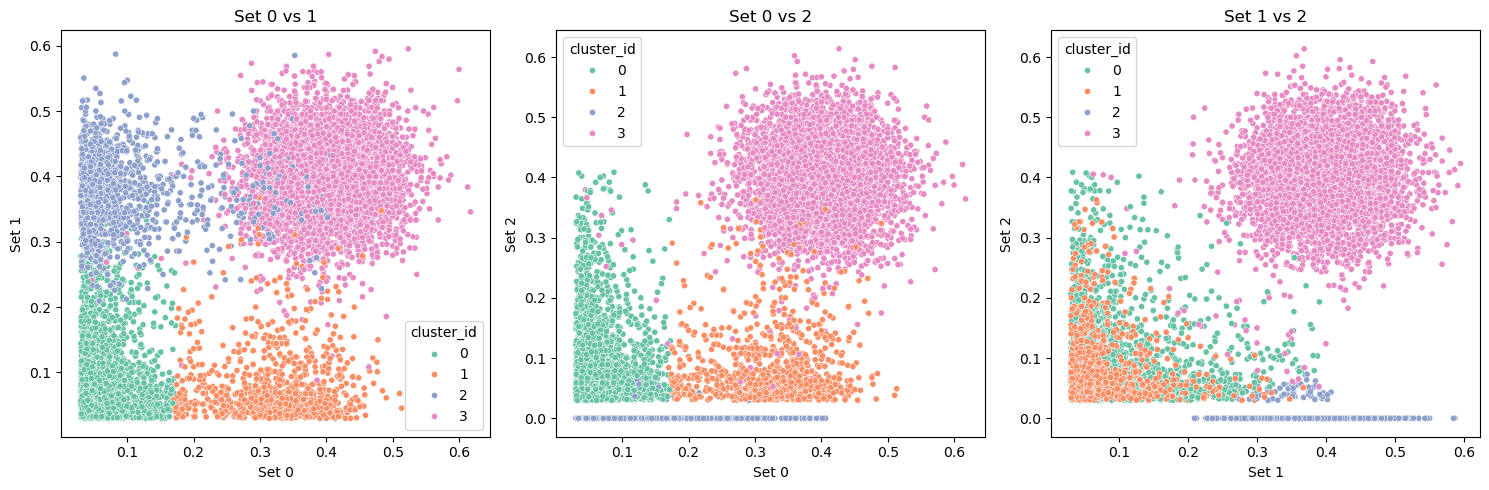

In [104]:
columns = [f"S_{i}" for i in range(D)]

D = NV.shape[1]  # Number of sets or columns
pairs = np.triu_indices(D, k=1)  # Generate all unique pairs of sets (i, j)
vaf = NV / DP  # Variant Allele Fraction
num_pairs = len(pairs[0])  # Number of unique pairs of scatter plots
ncols = min(3, num_pairs)  # Max 3 plots per row
nrows = (num_pairs + ncols - 1) // ncols  # Calculate number of rows needed

fig_width_per_plot = 5
fig_width = ncols * fig_width_per_plot
fig_height = 5 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

# Flatten axes to make iteration easier
axes = axes.flatten() if num_pairs > 1 else [axes] 

for ax, pair in zip(axes, zip(*pairs)):
    x_col, y_col = pair  # Unpack the pair of indices
    sns.scatterplot(data=table_to_print, x=f"S_{x_col}", y=f"S_{y_col}", hue='cluster_id', palette='Set2', ax=ax, s=20)
    ax.set_title(f'Set {x_col} vs {y_col}')
    ax.set_xlabel(f"Set {x_col}")
    ax.set_ylabel(f"Set {y_col}")


# Turn off any unused axes
for ax in axes[len(pairs[0]):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



In [107]:
result_sorted.iloc[np.where(result_sorted['Pred_cluster'] == 3)[0]]

,Pred_cluster,NV,DP,cellular_prevalence
0,3,"[44, 42, 31]","[91, 98, 89]","[0.5845, 0.5855, 0.5764]"
1,3,"[36, 39, 35]","[92, 105, 94]","[0.5845, 0.5855, 0.5764]"
2,3,"[35, 41, 35]","[85, 98, 94]","[0.5845, 0.5855, 0.5764]"
3,3,"[37, 40, 48]","[100, 109, 112]","[0.5845, 0.5855, 0.5764]"
4,3,"[44, 41, 29]","[106, 102, 112]","[0.5845, 0.5855, 0.5764]"
...,...,...,...,...
9858,3,"[39, 9, 36]","[101, 102, 90]","[0.5845, 0.5855, 0.5764]"
9887,3,"[34, 46, 6]","[104, 118, 114]","[0.5845, 0.5855, 0.5764]"
9926,3,"[34, 31, 13]","[102, 91, 121]","[0.5845, 0.5855, 0.5764]"
9990,3,"[29, 38, 10]","[99, 103, 119]","[0.5845, 0.5855, 0.5764]"


In [106]:
fit.groupby('cluster_id')['cellular_prevalence'].apply(lambda x: list(set(x))).reset_index()

,cluster_id,cellular_prevalence
0,0,"[0.101, 0.1313]"
1,1,"[0.4687, 0.1313, 0.1213]"
2,2,"[0.1414, 0.5534, 0.0]"
3,3,"[0.5845, 0.5855, 0.5764]"
